In [23]:
import pathlib
import os
from glob import glob

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 
import cloudpickle

import SessionTools.two_photon as st2p

import sklearn
from sklearn.linear_model import LinearRegression as LinReg


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['pdf.use14corefonts']=True

%load_ext autoreload
%autoreload 2 

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
data_dict = {'date': "05_02_2023",
             'fly': "EPG_GCaMP7f_CsChrimsontdT_fly1",
             'sessions': ('open_loop-003',
                          'open_loop_0deg-005',
                          'open_loop_180deg-008',
                         ),
             'res': []
}


In [25]:
fname = f"/media/mplitt/SSD_storage/2P_scratch/{data_dict['date']}/{data_dict['fly']}/combined_results.pkl"
with open(fname, 'rb') as file:
    data_dict = cloudpickle.load(file)

In [26]:
dff = [res['dff'] for res in data_dict['res']]
pva_angle = [res['pva']['angle'] for res in data_dict['res']]
heading = [res['heading'] for res in data_dict['res']]
heading_vel = [res['heading_vel'] for res in data_dict['res']]

offset = [res['bump_offset'] for res in data_dict['res']]


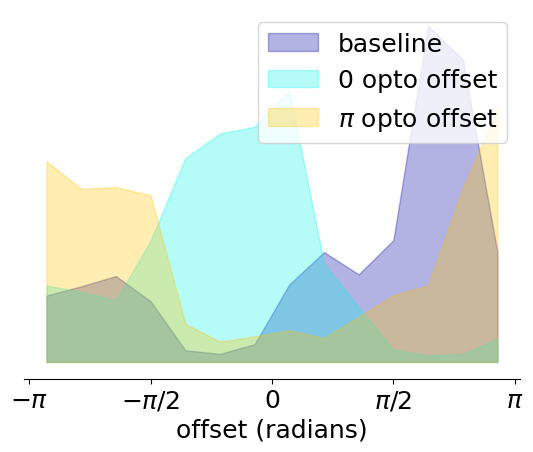

In [28]:
fig,ax = plt.subplots()
cmap = plt.cm.get_cmap('jet')
bin_edges = np.linspace(-np.pi, np.pi, num=15)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2.
labels = ('baseline', '0 opto offset', r'$\pi$ opto offset')
for i, (_offset, _heading_vel) in enumerate(zip(offset,heading_vel)):
    counts, _ = np.histogram(_offset,bins = bin_edges)
    ax.fill_between(bin_centers, counts/counts.sum(), alpha=.3, color=cmap(float(i+.1)/len(offset)), label=labels[i])
ax.legend(loc='upper right')

# ax.plot([0,0],[0,.15], color = cmap(.333))
# ax.plot([bin_centers[-1],bin_centers[-1]],[0,.15], color= cmap(.666))


[np.abs(_heading_vel)>.8]

ax.set_yticks([])
for s in ('top', 'left', 'right'):
    ax.spines[s].set_visible(False)
    
ax.set_xlabel('offset (radians)')

ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])



2.911095982328567


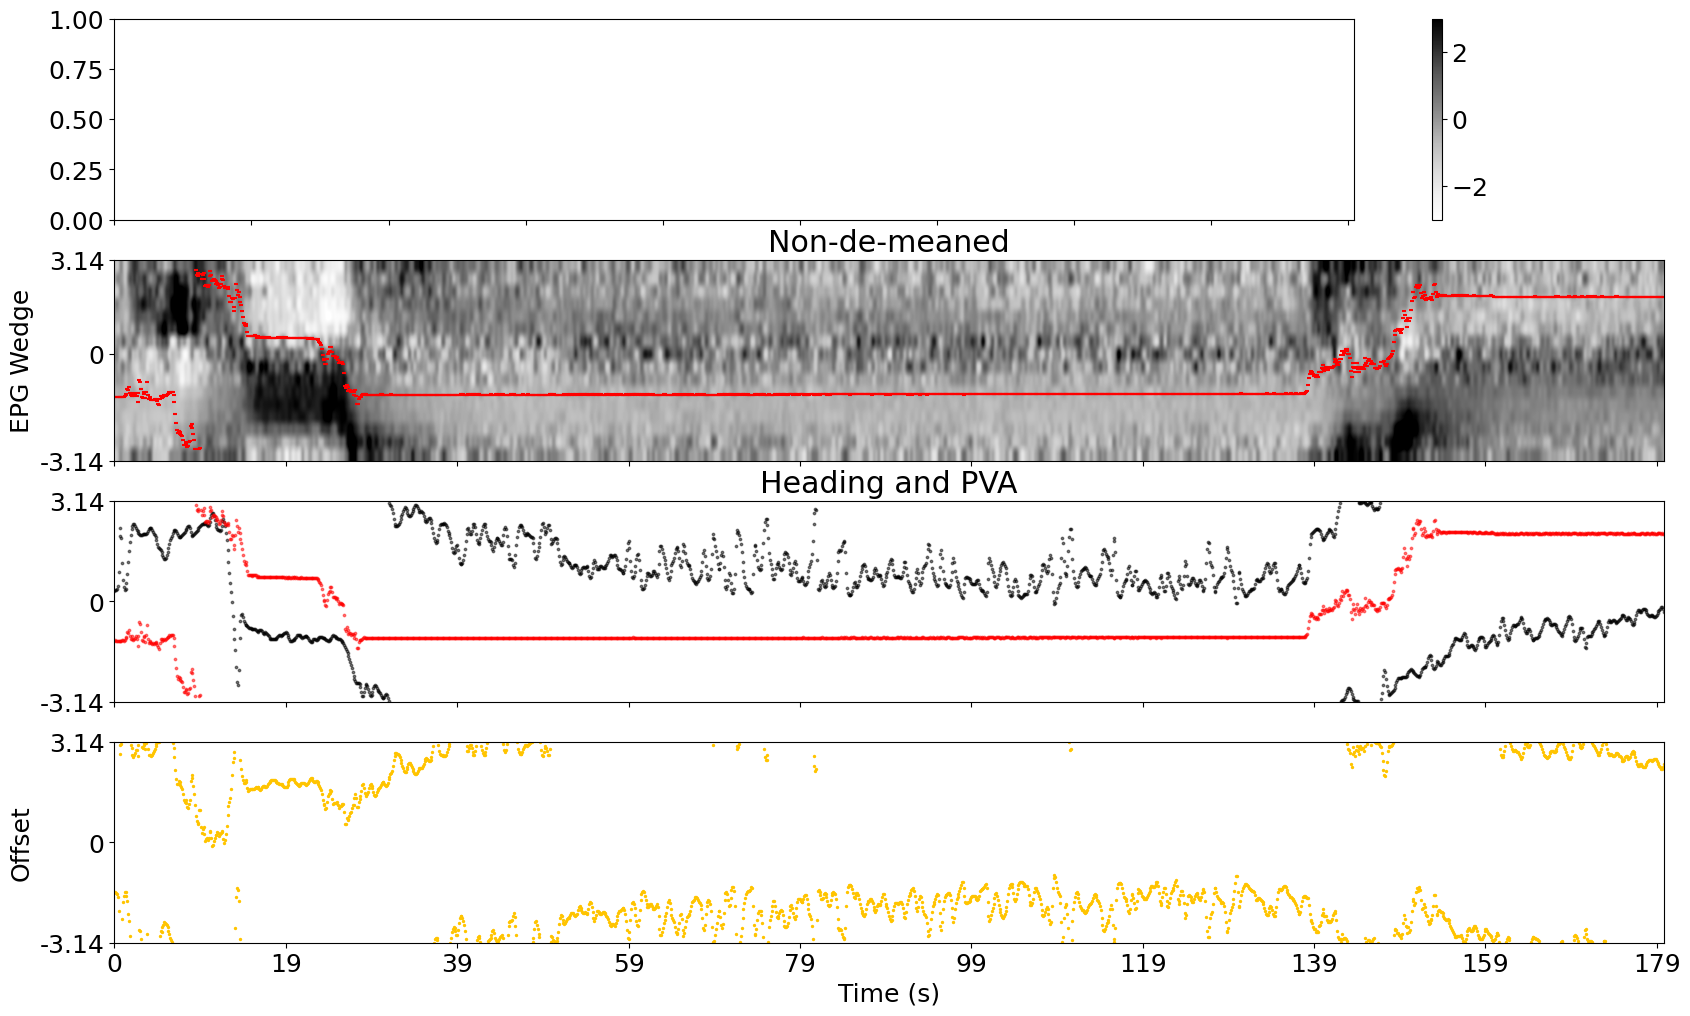

In [54]:

ind = 2

_dff = dff[ind]
_heading = heading[ind]
# print(_heading)
_pva_angle = np.angle(np.exp(1j*(pva_angle[ind])))

_offset = np.angle(np.exp(1j*(_heading-_pva_angle)))
mu_offset = np.angle(np.exp(1j*_offset).mean())

print(mu_offset)
vr = data_dict['res'][ind]['voltage_recording']
time = vr['Time(ms)'].to_numpy()
# time = time[:-5] - time[0]




x = np.arange(_dff.shape[1])
t = [str(int(time[i]/1000)) for i in range(0,x[-1]+1,500)]

#baseline 320, 500
# 0 deg: 10, 190
# 180 deg: 170, 350


tstart, tstop = 170, 350
window = (time>=tstart*1000 )*(time<=tstop*1000)






fig, ax = plt.subplots(4,1,figsize=[20,12], sharex=True)

_x = x[window]-x[window][0]
_t = (time[window]-time[window][0])/1000

im = ax[1].imshow(_dff[:,window], aspect='auto', cmap='Greys', vmin=-3,vmax=3)
ax[1].scatter(_x,15*(_heading[window]+np.pi)/2/np.pi,color='red',marker='_', s=10)
ax[1].set_yticks([-.5, 7, 15.5])
ax[1].set_yticklabels([3.14, 0, -3.14])
ax[1].set_ylabel('EPG Wedge')
ax[1].set_title('Non-de-meaned')



fig.colorbar(im,ax=ax[0])



cmap = plt.cm.get_cmap('jet')
ax[2].scatter(_x, _pva_angle[window], color='black', s=3, alpha=.5) #cmap(float(ind+.1)/len(offset)), s=3, alpha=.5)
ax[2].scatter(_x, _heading[window], color='red', s=3, alpha=.5)
ax[2].set_ylim([3.14,-3.14])
ax[2].set_yticks([-3.14,0,3.14])
ax[2].set_yticklabels([3.14, 0, -3.14])
ax[2].set_title('Heading and PVA')


ax[3].scatter(_x,_offset[window],s=2, color=cmap(float(ind+.1)/len(offset)))
ax[3].set_ylim([3.14,-3.14])
ax[3].set_yticks([-3.14,0,3.14])
ax[3].set_yticklabels([3.14, 0, -3.14])
ax[3].set_ylabel('Offset')
ax[3].set_xlabel('Time (s)')


ax[3].set_xticks(_x[::200], labels = [str(int(_t[i])) for i in range(0,_x.shape[0],200)])

basedir = pathlib.PurePath(f"/media/mplitt/SSD_storage/2P_scratch/{data_dict['date']}/{data_dict['fly']}/figs")
os.makedirs(basedir, exist_ok=True)
names = ['baseline', '0deg', '180deg']
fig_name = pathlib.Path(basedir.joinpath(f'dff_offset_{names[ind]}.pdf'))
fig.savefig(fig_name,format='pdf')

